In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import re

from tqdm import tqdm

random_state = 12345

In [39]:
train_ds = pd.read_csv('data/train_dataset.csv')
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37224 entries, 0 to 37223
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          37224 non-null  object 
 1   time          37224 non-null  int64  
 2   target        37224 non-null  float64
 3   temp          37224 non-null  float64
 4   temp_pred     37136 non-null  float64
 5   weather_pred  37136 non-null  object 
 6   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [40]:
train_ds['date'] = pd.to_datetime(train_ds['date'])
train_ds['year'] = train_ds['date'].dt.year
train_ds['month'] = train_ds['date'].dt.month
train_ds['day_of_week'] = train_ds['date'].dt.dayofweek
train_ds['day'] = train_ds['date'].dt.day
train_ds['day_of_year'] = train_ds['date'].dt.dayofyear

In [41]:
# функция формирует колонки 'cloudy', 'rainy', 'windy', 'clear', 'some_number'
# в колонках число, которое 0 при отсутсвии упоминания явления в weather_pred или степень упоминания
# функция дает в колонках номер первого списка, элемент которого есть в строке плюс 1
# списки cloudy_list, rainy_list, windy_list, clear_list можно модифицировать
# соответственно, можно экспериментировать с расположением значений в списках
# например, сейчас 'дождь', 'снег', 'д+сн' - первая степень  дождя, а 'гроз', 'ливень' - вторая
# а можно сделать снег второй, а грозу с ливнем убрать в третью
# также сделал отдельный список для "ясности", чтобы выделить 'ясно' и 'солнечно'

def in_what_list(weather, big_list):
    for list_number, small_list in enumerate(big_list):
        if any(word in weather for word in small_list):
            return list_number+1
    return 0

def weather_split2(row):
    weather = row['weather_pred']
    cloudy_list = [['проясн', 'пер.об.', 'п/об'], ['пасм', 'обл']]
    rainy_list = [['дождь', 'снег', 'д+сн'], ['гроз', 'ливень']]
    windy_list = [['вет'],['штор']]
    clear_list = [['проясн'], ['ясно'], ['солнеч']]
    numbers = re.findall(r'\d+', weather)
    cloudy = in_what_list(weather, cloudy_list)
    rainy = in_what_list(weather, rainy_list)
    windy = in_what_list(weather, windy_list)
    clear = in_what_list(weather, clear_list)
    rain_probability = 0 if len(numbers)==0 else int(numbers[0])
    has_rain_probability = int(len(numbers)==0)
    return cloudy, rainy, windy, clear, rain_probability, has_rain_probability

def fill_weather_columns(df):
    df['weather_pred'] = df['weather_pred'].fillna('')
    df['cloudy'], df['rainy'], df['windy'], df['clear'], df['rain_probability'], df['has_rain_probability'] = \
                zip(*df.apply(weather_split2, axis=1))
    return df

train_ds = fill_weather_columns(train_ds)



In [42]:
#tmpds[(tmpds['cloudy']==0) & (tmpds['clear']==0) & (tmpds['rainy']==0)]['weather_pred'].value_counts()

In [43]:
train_ds.columns

Index(['date', 'time', 'target', 'temp', 'temp_pred', 'weather_pred',
       'weather_fact', 'year', 'month', 'day_of_week', 'day', 'day_of_year',
       'cloudy', 'rainy', 'windy', 'clear', 'rain_probability',
       'has_rain_probability'],
      dtype='object')

In [44]:
feature_cols = list(train_ds.columns)
drop_list = ['target', 'date', 'day_of_year', 'weather_pred', 'weather_fact', 'temp']
for name in drop_list:
    feature_cols.remove(name)

features = train_ds[feature_cols]
target = train_ds['target']

In [45]:
features_train = features[features['year']<2023]
target_train = target[features_train.index]
features_valid = features[features['year']==2023]
target_valid = target[features_valid.index]

In [46]:
features_train = features[features['year']<2022]
target_train = target[features_train.index]
features_valid = features[features['year']==2022]
target_valid = target[features_valid.index]

In [47]:
def mae_day(y_true, y_pred):
    y_true_copy = pd.DataFrame(y_true).reset_index(drop=True)
    y_true_copy['day'] = y_true_copy.index // 24
    y_true_grouped = y_true_copy.groupby(by='day').sum()   
    y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
    y_pred_copy['day'] = y_pred_copy.index // 24
    y_pred_grouped = y_pred_copy.groupby(by='day').sum()
    
    return mean_absolute_error(y_true_grouped, y_pred_grouped)

In [48]:
# класс предлагается инициализировать, затем брать значения параметра из current_value 
# и регистрировать значения метрики методом add_metric_value, пока add_metric_value не вернет True

# параметры инициализации: 
# initial_values - начальный вектор значений параметра, может быть любой длины
# stop_relation - целевое отношение соседних значений параметра для остановки поиска
# step_method - способ формирования трех точек для первой параболы дугой вниз
# step_method = 'geometric' - делим или умножаем значение с минимальной метрикой на geometric_step
# step_method = 'dichotomy' - делим интервал с минимальной метрикой на границах пополам
# step_method = 'geometric_dichotomy' - делим интервал с минимальной метрикой на границах средним геометрическим

class one_parameter_parabolic_optimizer:
    def __init__(self, initial_values, stop_relation=1.1, step_method='nothing', geometric_step=2):      
        self.data = pd.DataFrame(columns=('parameter','metric','x2','x','1'), dtype='float')
        self.parabolic_mode = False
        self.parabolic_error = False
        self.stop_relation_log = np.log(stop_relation)
        self.initial_values = initial_values            
        self.step_method = step_method                              
        self.geometric_step = geometric_step
        self.initial_counter = 0
        self.current_value = self.initial_values[0]
        
    def best_value(self):
        return self.data.loc[self.data['metric'].idxmin(), 'parameter']
    
# строим параболу через точку с минимальной метрикой и две соседние и ищем ее минимум
    def next_parabolic(self):                      
        self.data['x2'] = self.data['parameter']**2
        self.data['x'] = self.data['parameter']
        self.data['1'] = 1
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()
        matrix = self.data[['x2','x','1']][index_min-1:index_min+2]
        y = self.data['metric'][index_min-1:index_min+2]
        vector_abc = np.linalg.inv(matrix) @ y
        return -vector_abc[1]/vector_abc[0]/2

    def next_geometric(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return self.data.loc[index_min, 'parameter']/self.geometric_step
        else:
            return self.data.loc[index_min, 'parameter']*self.geometric_step
        
    def next_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min+1, 'parameter'])/2
        else:
            return (self.data.loc[index_min, 'parameter'] + self.data.loc[index_min-1, 'parameter'])/2
        
    def next_geometric_dichotomy(self):
        index_min = self.data['metric'].idxmin()
        if index_min==0:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min+1, 'parameter'])**0.5
        else:
            return (self.data.loc[index_min, 'parameter'] * self.data.loc[index_min-1, 'parameter'])**0.5
    
    def add_metric_value(self, metric_value):
        if self.parabolic_error:           # записана ошибка, выход
                return True
        self.data.loc[self.data.shape[0]] = [self.current_value, metric_value, 0, 0, 0]   # новое значение в таблицу
        if self.initial_counter+1 < len(self.initial_values) :              # если начальные значения не закончились,
            self.initial_counter+=1                                         # то считаем метрику в них
            self.current_value = self.initial_values[self.initial_counter]
            return False
        self.data = self.data.astype(float).sort_values(by='parameter', ascending=True).reset_index(drop=True)
        index_min = self.data['metric'].idxmin()         # ищем минимальную метрику
        parabolic_ready = (index_min!=0) and (index_min!=self.data.shape[0]-1)      # и выясняем, на краю ли она таблицы
        if parabolic_ready:
            self.parabolic_mode = True                               # если не на краю, дальше считаем параболой                  
            self.current_value = self.next_parabolic()
            loglog = abs(np.array([np.log(self.data.loc[index_min-1,'parameter'])-np.log(self.data.loc[index_min,'parameter']),
                              np.log(self.data.loc[index_min+1,'parameter']) -np.log(self.data.loc[index_min,'parameter'])]))            
            return loglog.min() < self.stop_relation_log   # пока не выполним критерий
        elif self.parabolic_mode:    # если уже была парабола, а теперь не получается, то пишем ошибку: метод расходится
            return True
        elif self.step_method == 'geometric': # если еще нет точек для параболы и задана геометрическая прогрессия
            self.current_value = self.next_geometric()
            return False
        elif self.step_method == 'dichotomy': # если еще нет точек для параболы и задана дихотомия 
            self.current_value = self.next_dichotomy()
            return False
        elif self.step_method == 'geometric_dichotomy': # если еще нет точек для параболы и задана geometric_dichotomy 
            self.current_value = self.next_geometric_dichotomy()
            return False
        else: # если еще нет точек для параболы и метод поиска не задан, завершаем
            return True

In [49]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.01], 1.03, step_method='geometric')
for i in range(10):
    learning_rate = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=7, learning_rate=learning_rate, num_iterations=5000, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    mae = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'learning rate = {learning_rate:.5f} mae = {mae:.1f}')
    if optimizer.add_metric_value(mae):
        break
best_learning_rate_1000 = optimizer.best_value()

c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01000 mae = 327.7


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.00500 mae = 336.7


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.02000 mae = 335.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01272 mae = 327.7


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01136 mae = 329.7


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01453 mae = 331.8


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


learning rate = 0.01267 mae = 329.7
CPU times: total: 1min 6s
Wall time: 20.4 s


In [50]:
%%time
optimizer = one_parameter_parabolic_optimizer([0.2, 1], 1.03, step_method='dichotomy')
for i in range(10):
    feature_fraction = optimizer.current_value
    lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000,  
                               num_iterations=5000, 
                               feature_fraction=feature_fraction, random_state=random_state)
    lgbm_model.fit(features_train, target_train)
    rmse = mae_day(target_valid, lgbm_model.predict(features_valid))
    print(f'feature_fraction = {feature_fraction:.5f} rmse = {rmse:.1f}')
    if optimizer.add_metric_value(rmse):
        break
best_feature_fraction = optimizer.best_value()

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.20000 rmse = 337.6
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 1.00000 rmse = 346.0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.60000 rmse = 324.3
[LightGBM] [Warning] feature_fraction is set=0.5521400693473023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5521400693473023


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.55214 rmse = 324.3
[LightGBM] [Warning] feature_fraction is set=0.5760700346736763, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5760700346736763


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.57607 rmse = 324.3
[LightGBM] [Warning] feature_fraction is set=0.5641050520104471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5641050520104471


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


feature_fraction = 0.56411 rmse = 324.3
CPU times: total: 1min 15s
Wall time: 22.7 s


In [51]:
lgbm_model = lgb.LGBMRegressor(num_leaves=15, learning_rate=best_learning_rate_1000, num_iterations=5000, 
                               feature_fraction=best_feature_fraction, random_state=random_state)
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] feature_fraction is set=0.5521400693473023, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5521400693473023


c:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


LGBMRegressor(feature_fraction=0.5521400693473023,
              learning_rate=0.012717531332913016, num_iterations=5000,
              num_leaves=15, random_state=12345)

In [52]:
y_pred = lgbm_model.predict(features_valid)
mae = mae_day(target_valid, y_pred)
print(mae)
mean_absolute_error(target_valid, y_pred)

324.31999009069017


15.478798196677023

In [53]:
y_true_copy = pd.DataFrame(target_valid).reset_index(drop=True)
y_true_copy['day'] = y_true_copy.index // 24
y_true_grouped = y_true_copy.groupby(by='day').sum()   
y_true_grouped
y_pred_copy = pd.DataFrame(y_pred).reset_index(drop=True)
y_pred_copy['day'] = y_pred_copy.index // 24
y_pred_grouped = y_pred_copy.groupby(by='day').sum()

<AxesSubplot:xlabel='day'>

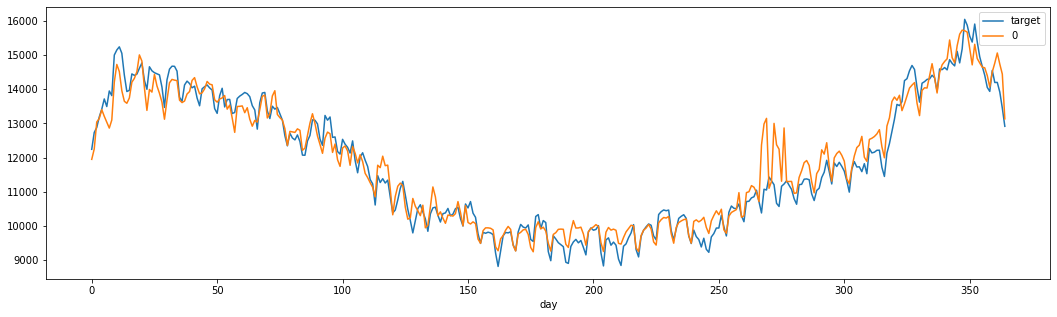

In [54]:
y_true_grouped.plot(figsize=(18,5))
ax=plt.gca()
y_pred_grouped.plot(ax=ax)

In [55]:
y_true_grouped['target'][1]

12734.276

<AxesSubplot:ylabel='0'>

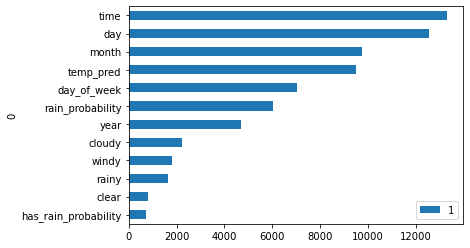

In [56]:
feature_importances = pd.DataFrame([feature_cols, lgbm_model.feature_importances_]).T.sort_values(by = 1)
#feature_importances.plot(kind='bar')
feature_importances.plot(kind='barh', x=0, y=1)